In [3]:
import os
import pickle
from dassl.data.datasets import Datum
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
import umap
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

/home/yhiro/miniconda3/envs/dassl2/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


(0.0, 10.0)

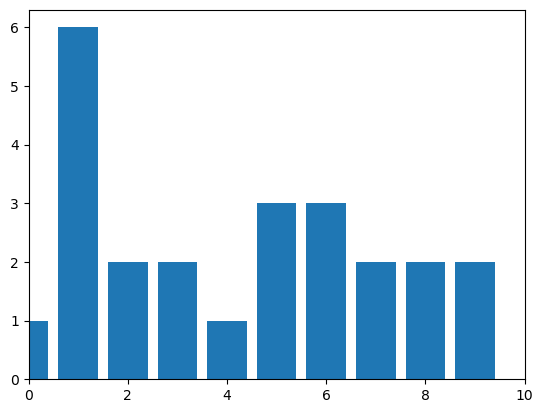

In [24]:
path = "/data2/yhiro/data/eurosat_active/split_fewshot"
with open(os.path.join(path, "shot_1-seed_2-active.pkl"), "rb") as file:
    shot1= pickle.load(file)


active_label = [d.label for d in shot1]

count = Counter(active_label)

height = []
for i in range(len(active_label)):
    if i not in count.keys():
        height.append(0)
    else:
        height.append(count[i])
plt.bar(range(len(height)), height)
plt.xlim(0,10)
#plt.ylim(0,8.2)
#[print(d.label) for d in shot1]
#print("--------")
#[print(d.label) for d in shot2["train"]]

/home/yhiro/miniconda3/envs/dassl2/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


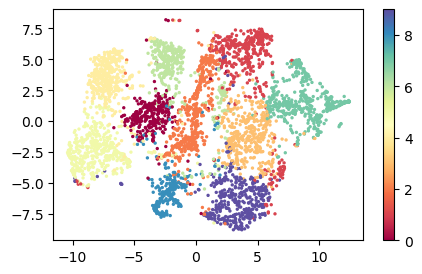

In [22]:
filepath = "output/ZeroshotCLIP_ETran/vit_b16"
dname = "eurosat"
K = 10
img_features = np.load(os.path.join(filepath, dname, "features.npy"))
labels = np.load(os.path.join(filepath, dname, "labels.npy"))

sample_size = 4000  # Define the number of points to sample
indices = np.random.choice(img_features.shape[0], sample_size, replace=False)
img_features = img_features[indices]
labels = labels[indices]

kmeans = KMeans(n_clusters=K, random_state=42)
kmeans.fit(img_features)
labels_kmeans = kmeans.labels_

img_features_concat = np.concatenate((img_features, kmeans.cluster_centers_))

tsne_model = TSNE(n_components=2, perplexity=30, n_iter=300, random_state=42)
embedding = tsne_model.fit_transform(img_features_concat)

embedding_img = embedding[:-K]

cluster_centers = embedding[-K:]

# Plot the UMAP embedding
plt.figure(figsize=(5, 3))
#plt.scatter(embedding_img[:, 0], embedding_img[:, 1], s=2, cmap='Spectral', c=labels)

plt.scatter(embedding_img[:, 0], embedding_img[:, 1], s=2, cmap='Spectral', c=labels_kmeans)
#plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], s=5, c="red" ,marker="X")

plt.colorbar()
#plt.title('UMAP Projection of (8100, 512) Features')
#plt.xlabel('UMAP Dimension 1')
#plt.ylabel('UMAP Dimension 2')
plt.show()


In [20]:
from sklearn.metrics import pairwise_distances

distance = pairwise_distances(kmeans.cluster_centers_, img_features)
for d in distance:
    d_minid = np.argsort(d)


array([4009,  458, 3139, ..., 2206,  663, 3749])

In [6]:
import numpy as np
a=np.array([1,2,3,4,5])
idx={1,2,3}
idx=np.array(list(idx))
a[idx]

array([2, 3, 4])

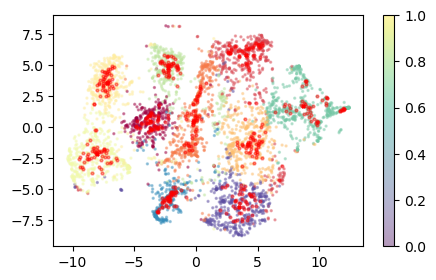

In [31]:
# Plot the UMAP embedding
plt.figure(figsize=(5, 3))
#plt.scatter(embedding_img[:, 0], embedding_img[:, 1], s=2, cmap='Spectral', c=labels)

plt.scatter(embedding_img[:, 0], embedding_img[:, 1], s=2, cmap='Spectral', c=labels_kmeans, alpha=0.4)
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], s=5, c="red" ,marker="X")


distance = pairwise_distances(kmeans.cluster_centers_, img_features)
for d in distance:
    d_minid = np.argsort(d)
    d_minid = d_minid[:50]
    plt.scatter(embedding_img[d_minid, 0], embedding_img[d_minid, 1], s=5, alpha=0.4, c="red", marker="H")


plt.colorbar()
#plt.title('UMAP Projection of (8100, 512) Features')
#plt.xlabel('UMAP Dimension 1')
#plt.ylabel('UMAP Dimension 2')
plt.show()


In [6]:
a=[1,2,3,4,5]
a[-2:]

[4, 5]